# Prédiction Conforme en Classification

## Objectif

L’objectif de ce notebook est d’appliquer la **prédiction conforme** pour la classification des ratings de crédit d'entreprises. L'objectif est de créer des ensembles de prédiction avec des garanties statistiques de couverture.
Ces ensembles traduisent l’incertitude du modèle en listant les classes possibles pour chaque observation avec une probabilité de couverture donnée.

## 🧩 Plan du notebook

1. **Préparation des données**
   - Encodage des features catégorielles
   - Séparation entraînement / calibration / test

2. **Entraînement du modèle de base**
   - Modèles considérés : LogisticRegression, RandomForestClassifier
   - Évaluation des performances classiques (accuracy, F1-score)

3. **Implémentation des méthodes de prédiction conforme**
   - **SCP (Split Conformal Prediction)**  
     Méthode la plus courante en classification, simple à implémenter et efficace sur des grands jeux de données.
   - **FCP (Full Conformal Prediction)**  
     Méthode exhaustive qui offre une couverture optimale, mais dont le coût d’entraînement est plus élevé.  
     Elle est envisageable seulement si le temps de calcul est raisonnable et si la discrétisation des scores de probabilité est stable.

4. **Évaluation et visualisation**
   - Taux de couverture observé (proportion de vrais labels inclus dans les ensembles prédits)
   - Taille moyenne des ensembles de prédiction
   - Analyse de la relation entre confiance du modèle et taille de l’ensemble conforme

5. **Analyse critique**
   - Discussion sur la pertinence des méthodes selon la taille du jeu de données, le temps d’entraînement, et les besoins métiers.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import sys
sys.path.append('../src')
from data_loading import load_classification_data
from preprocessing import group_credit_ratings

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## 1. Chargement et préparation des données

In [2]:
df = load_classification_data()
df.head()

Chargement du dataset de classification: /home/r-one/Documents/epita/stochastique/Prediction-Conforme-et-Regression-Quantile-sur-le-Risque-de-Credit/data/raw/corporate_rating.csv
Dataset chargé: 2029 lignes, 31 colonnes


,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


In [3]:
df['Rating'] = group_credit_ratings(df['Rating'])

Regroupement des ratings de crédit...
Distribution originale:
Rating
A      398
AA      89
AAA      7
B      302
BB     490
BBB    671
C        2
CC       5
CCC     64
D        1
Name: count, dtype: int64

Distribution après regroupement:
Rating
IG_HIGH       96
IG_LOW       671
IG_MED       398
SPEC_HIGH    490
SPEC_LOW      72
SPEC_MED     302
Name: count, dtype: int64


In [4]:
# Préparation des features et de la cible
X = df.drop('Rating', axis=1)
y = df['Rating']

# Encodage de la variable cible
le = LabelEncoder()
y_encoded = le.fit_transform(y)

### Encodage des variables catégorielles

In [5]:
from sklearn.preprocessing import LabelEncoder

X_processed = X.copy()

# Suppression des colonnes Name, Symbol
X_processed = X_processed.drop(['Name', 'Symbol'], axis=1)

# Extraction de l'année
X_processed['Year'] = pd.to_datetime(X_processed['Date']).dt.year
X_processed = X_processed.drop('Date', axis=1)

# Encodage des variables catégorielles
categorical_cols = ['Rating Agency Name', 'Sector']

for col in categorical_cols:
    le_temp = LabelEncoder()
    X_processed[col] = le_temp.fit_transform(X_processed[col].astype(str))

print(f"Shape après traitement : {X_processed.shape}")
print(f"\nTypes de données :")
print(X_processed.dtypes.value_counts())
print(f"\nPremières lignes :")
X_processed.head()

Shape après traitement : (2029, 28)

Types de données :
float64    25
int64       2
int32       1
Name: count, dtype: int64

Premières lignes :


,Rating Agency Name,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,...,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover,Year
0,1,2,0.945894,0.426395,0.099690,44.203245,0.037480,0.049351,0.176631,0.061510,...,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655,2015
1,1,2,1.033559,0.498234,0.203120,38.991156,0.044062,0.048857,0.175715,0.066546,...,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846,2014
2,2,2,0.963703,0.451505,0.122099,50.841385,0.032709,0.044334,0.170843,0.059783,...,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510,2015
3,2,2,1.019851,0.510402,0.176116,41.161738,0.020894,-0.012858,0.138059,0.042430,...,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150,2012
4,4,2,0.957844,0.495432,0.141608,47.761126,0.042861,0.053770,0.177720,0.065354,...,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790,2016


In [6]:
print("Colonnes dans X_processed:")
print(X_processed.columns.tolist())

Colonnes dans X_processed:
['Rating Agency Name', 'Sector', 'currentRatio', 'quickRatio', 'cashRatio', 'daysOfSalesOutstanding', 'netProfitMargin', 'pretaxProfitMargin', 'grossProfitMargin', 'operatingProfitMargin', 'returnOnAssets', 'returnOnCapitalEmployed', 'returnOnEquity', 'assetTurnover', 'fixedAssetTurnover', 'debtEquityRatio', 'debtRatio', 'effectiveTaxRate', 'freeCashFlowOperatingCashFlowRatio', 'freeCashFlowPerShare', 'cashPerShare', 'companyEquityMultiplier', 'ebitPerRevenue', 'enterpriseValueMultiple', 'operatingCashFlowPerShare', 'operatingCashFlowSalesRatio', 'payablesTurnover', 'Year']


## 2. Division des données Train/Calibration/Test

In [7]:
# Division en train (50%), calibration (40%), test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded
)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.44, random_state=42, stratify=y_temp
)

print(f"Taille train : {X_train.shape[0]}")
print(f"Taille calibration : {X_calib.shape[0]}")
print(f"Taille test : {X_test.shape[0]}")
print(f"\nClasses : {le.classes_}")

Taille train : 1022
Taille calibration : 804
Taille test : 203

Classes : ['IG_HIGH' 'IG_LOW' 'IG_MED' 'SPEC_HIGH' 'SPEC_LOW' 'SPEC_MED']


## 3. Entraînement du modèle de base

Précision sur calibration : 0.485


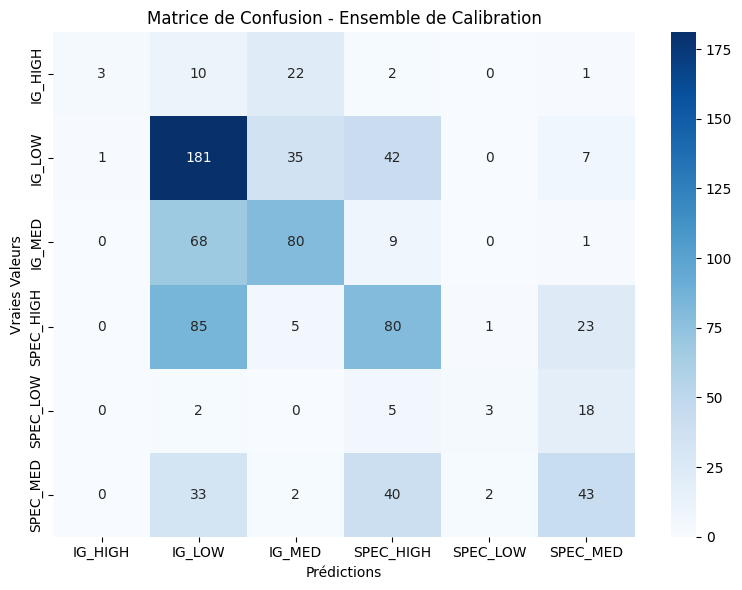

In [8]:
# Entraînement Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10,
    min_samples_split=10
)

rf_model.fit(X_train, y_train)

y_calib_pred = rf_model.predict(X_calib)
calib_accuracy = accuracy_score(y_calib, y_calib_pred)

print(f"Précision sur calibration : {calib_accuracy:.3f}")

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_calib, y_calib_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion - Ensemble de Calibration')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.tight_layout()
plt.show()

## 4. Implémentation de la Prédiction Conforme

In [ ]:
class SplitConformalPrediction:
    """
    Split Conformal Prediction (SCP) pour la classification.
    
    Cette méthode divise les données en deux ensembles :
    - Un pour entraîner le modèle
    - Un pour calibrer les scores de non-conformité
    
    La fonction de score utilisée est la somme cumulée des probabilités
    jusqu'à atteindre la vraie classe (ordre décroissant).
    """
    def __init__(self, model):
        self.model = model
        self.q_hat = None
        
    def score(self, probs, true_label):
        # Score = somme cumulée des probas jusqu'à la vraie classe
        sorted_indices = np.argsort(probs)[::-1]
        cumsum = 0
        for idx in sorted_indices:
            cumsum += probs[idx]
            if idx == true_label:
                return cumsum
        return cumsum
    
    def calibrate(self, X_calib, y_calib, alpha=0.1):
        probs_calib = self.model.predict_proba(X_calib)
        
        scores = np.array([
            self.score(probs_calib[i], y_calib[i]) 
            for i in range(len(y_calib))
        ])
        
        n = len(scores)
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        self.q_hat = np.quantile(scores, q_level)
        
        print(f"SCP calibrée avec {n} observations")
        
    def predict(self, X):
        if self.q_hat is None:
            raise ValueError("Le modèle doit être calibré avant la prédiction.")
        
        probs = self.model.predict_proba(X)
        
        prediction_sets = []
        for i in range(len(X)):
            sorted_indices = np.argsort(probs[i])[::-1]
            
            cumsum = 0
            pred_set = []
            for idx in sorted_indices:
                cumsum += probs[i, idx]
                pred_set.append(idx)
                if cumsum >= self.q_hat:
                    break
            
            prediction_sets.append(pred_set)
        
        return prediction_sets

In [ ]:
class FullConformalPrediction:
    """
    Full Conformal Prediction (FCP) pour la classification.
    
    Cette méthode calcule des p-values pour chaque classe candidate
    en comparant les scores de non-conformité.
    """
    def __init__(self, model):
        self.model = model
        self.calib_scores = None
        self.n_classes = None
        
    def score(self, probs, label):
        sorted_indices = np.argsort(probs)[::-1]
        cumsum = 0
        for idx in sorted_indices:
            cumsum += probs[idx]
            if idx == label:
                return cumsum
        return cumsum
    
    def calibrate(self, X_calib, y_calib):
        self.n_classes = len(np.unique(y_calib))
        
        probs_calib = self.model.predict_proba(X_calib)
        self.calib_scores = np.array([
            self.score(probs_calib[i], y_calib[i])
            for i in range(len(y_calib))
        ])
        
        print(f"FCP calibrée avec {len(self.calib_scores)} observations")
    
    def predict(self, X, alpha=0.1):
        if self.calib_scores is None:
            raise ValueError("Le modèle doit être calibré avant la prédiction.")
        
        probs_test = self.model.predict_proba(X)
        
        prediction_sets = []
        for i in range(len(X)):
            pred_set = []
            
            for label in range(self.n_classes):
                test_score = self.score(probs_test[i], label)
                
                n = len(self.calib_scores)
                p_value = (np.sum(self.calib_scores >= test_score) + 1) / (n + 1)
                
                if p_value >= alpha:
                    pred_set.append(label)
            
            if len(pred_set) == 0:
                pred_set.append(np.argmax(probs_test[i]))
            
            prediction_sets.append(pred_set)
        
        return prediction_sets

### Application de la FCP

In [11]:
# Application FCP avec alpha = 0.1
from sklearn.ensemble import RandomForestClassifier

fcp = FullConformalPrediction(rf_model)
fcp.calibrate(X_calib, y_calib)

fcp_predictions = fcp.predict(X_test, alpha=0.1)

print(f"\nExemples d'ensembles de prédiction (FCP) :")
for i in range(5):
    pred_classes = [le.classes_[c] for c in fcp_predictions[i]]
    true_class = le.classes_[y_test[i]]
    print(f"Obs {i+1}: Ensemble = {pred_classes}, Vrai = {true_class}")

FCP calibrée avec 804 observations

Exemples d'ensembles de prédiction (FCP) :
Obs 1: Ensemble = ['SPEC_HIGH', 'SPEC_MED'], Vrai = SPEC_HIGH
Obs 2: Ensemble = ['IG_LOW', 'IG_MED'], Vrai = SPEC_HIGH
Obs 3: Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH'], Vrai = IG_LOW
Obs 4: Ensemble = ['IG_LOW', 'SPEC_HIGH', 'SPEC_MED'], Vrai = SPEC_HIGH
Obs 5: Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH', 'SPEC_MED'], Vrai = IG_HIGH


### Application de la SCP

In [12]:
# Application SCP avec alpha = 0.1
scp = SplitConformalPrediction(rf_model)
scp.calibrate(X_calib, y_calib, alpha=0.1)

scp_predictions = scp.predict(X_test)

print(f"\nExemples d'ensembles de prédiction (SCP) :")
for i in range(5):
    pred_classes = [le.classes_[c] for c in scp_predictions[i]]
    true_class = le.classes_[y_test[i]]
    print(f"Obs {i+1}: Ensemble = {pred_classes}, Vrai = {true_class}")

SCP calibrée avec 804 observations

Exemples d'ensembles de prédiction (SCP) :
Obs 1: Ensemble = ['SPEC_MED', 'SPEC_HIGH', 'IG_LOW'], Vrai = SPEC_HIGH
Obs 2: Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH'], Vrai = SPEC_HIGH
Obs 3: Ensemble = ['IG_LOW', 'IG_MED', 'SPEC_HIGH', 'IG_HIGH'], Vrai = IG_LOW
Obs 4: Ensemble = ['SPEC_HIGH', 'SPEC_MED', 'IG_LOW', 'SPEC_LOW'], Vrai = SPEC_HIGH
Obs 5: Ensemble = ['IG_MED', 'IG_LOW', 'SPEC_HIGH', 'SPEC_MED', 'IG_HIGH'], Vrai = IG_HIGH


## 5. Évaluation de la couverture

In [13]:
def evaluate_coverage(prediction_sets, y_true):
    n = len(prediction_sets)
    coverage = sum([y_true[i] in prediction_sets[i] for i in range(n)]) / n
    avg_size = np.mean([len(s) for s in prediction_sets])
    return coverage, avg_size

# Évaluation SCP
scp_coverage, scp_avg_size = evaluate_coverage(scp_predictions, y_test)
print("=== Split Conformal Prediction (SCP) ===")
print(f"Taux de couverture : {scp_coverage:.2%}")
print(f"Taille moyenne des ensembles : {scp_avg_size:.2f}")

# Évaluation FCP
fcp_coverage, fcp_avg_size = evaluate_coverage(fcp_predictions, y_test)
print("\n=== Full Conformal Prediction (FCP) ===")
print(f"Taux de couverture : {fcp_coverage:.2%}")
print(f"Taille moyenne des ensembles : {fcp_avg_size:.2f}")

print(f"\n✓ Objectif : ≥ 90% de couverture avec alpha = 0.1")

=== Split Conformal Prediction (SCP) ===
Taux de couverture : 97.04%
Taille moyenne des ensembles : 3.95

=== Full Conformal Prediction (FCP) ===
Taux de couverture : 87.19%
Taille moyenne des ensembles : 2.95

✓ Objectif : ≥ 90% de couverture avec alpha = 0.1


### Optimisation de l'alpha

In [14]:
# Test de différentes valeurs d'alpha pour SCP
print("=== Optimisation alpha pour SCP ===\n")

alpha_values = [0.05, 0.08, 0.10, 0.12, 0.15]

for alpha in alpha_values:
    scp_temp = SplitConformalPrediction(rf_model)
    scp_temp.calibrate(X_calib, y_calib, alpha=alpha)
    pred_temp = scp_temp.predict(X_test)
    coverage, avg_size = evaluate_coverage(pred_temp, y_test)
    
    print(f"Alpha = {alpha:.2f} (confiance = {(1-alpha)*100:.0f}%)")
    print(f"Couverture : {coverage:.2%}")
    print(f"Taille moyenne : {avg_size:.2f}")
    print()

print("\n=== Optimisation alpha pour FCP ===\n")

for alpha in alpha_values:
    pred_temp = fcp.predict(X_test, alpha=alpha)
    coverage, avg_size = evaluate_coverage(pred_temp, y_test)
    
    print(f"Alpha = {alpha:.2f} (confiance = {(1-alpha)*100:.0f}%)")
    print(f"Couverture : {coverage:.2%}")
    print(f"Taille moyenne : {avg_size:.2f}")
    print()

=== Optimisation alpha pour SCP ===

SCP calibrée avec 804 observations
Alpha = 0.05 (confiance = 95%)
Couverture : 98.52%
Taille moyenne : 4.40

SCP calibrée avec 804 observations
Alpha = 0.08 (confiance = 92%)
Couverture : 98.03%
Taille moyenne : 4.17

SCP calibrée avec 804 observations
Alpha = 0.10 (confiance = 90%)
Couverture : 97.04%
Taille moyenne : 3.95

SCP calibrée avec 804 observations
Alpha = 0.12 (confiance = 88%)
Couverture : 96.55%
Taille moyenne : 3.78

SCP calibrée avec 804 observations
Alpha = 0.15 (confiance = 85%)
Couverture : 94.09%
Taille moyenne : 3.49


=== Optimisation alpha pour FCP ===

Alpha = 0.05 (confiance = 95%)
Couverture : 91.13%
Taille moyenne : 3.40

Alpha = 0.08 (confiance = 92%)
Couverture : 89.16%
Taille moyenne : 3.17

Alpha = 0.10 (confiance = 90%)
Couverture : 87.19%
Taille moyenne : 2.95

Alpha = 0.12 (confiance = 88%)
Couverture : 85.22%
Taille moyenne : 2.78

Alpha = 0.15 (confiance = 85%)
Couverture : 81.28%
Taille moyenne : 2.49

Alpha = 0.

### Application des alphas optimaux

**Résultats de l'analyse :**
- **SCP** : Pour avoir une taille moyenne de 3 éléments tout en maintenant ≥90% de couverture, il faut utiliser **alpha = 0.15** (couverture = 94.09%, taille = 3.49)
- **FCP** : Pour atteindre ≥90% de couverture, il faut **alpha = 0.05** (couverture = 91.13%, taille = 3.40)

## 6. Analyse détaillée des prédictions

In [15]:
# Visualisation de quelques exemples
n_examples = 30
np.random.seed(42)
indices = np.random.choice(len(X_test), n_examples, replace=False)

results_data = []

for idx in indices:
    true_label = le.classes_[y_test[idx]]
    scp_set = [le.classes_[c] for c in scp_predictions[idx]]
    fcp_set = [le.classes_[c] for c in fcp_predictions[idx]]
    
    scp_ok = "VRAI" if y_test[idx] in scp_predictions[idx] else "FAUX"
    fcp_ok = "VRAI" if y_test[idx] in fcp_predictions[idx] else "FAUX"

    results_data.append({
        'Index': idx,
        'Vraie Classe': true_label,
        'SCP Ensemble': ', '.join(scp_set),
        'SCP Taille': len(scp_set),
        'SCP Valide': scp_ok,
        'FCP Ensemble': ', '.join(fcp_set),
        'FCP Taille': len(fcp_set),
        'FCP Valide': fcp_ok
    })

results_df = pd.DataFrame(results_data)

print("Comparaison SCP vs FCP :\n")
print(results_df.to_string(index=False))

Comparaison SCP vs FCP :

 Index Vraie Classe                                  SCP Ensemble  SCP Taille SCP Valide                        FCP Ensemble  FCP Taille FCP Valide
    15       IG_LOW           SPEC_HIGH, IG_LOW, SPEC_MED, IG_MED           4       VRAI         IG_LOW, SPEC_HIGH, SPEC_MED           3       VRAI
     9       IG_LOW            IG_LOW, IG_MED, SPEC_HIGH, IG_HIGH           4       VRAI           IG_LOW, IG_MED, SPEC_HIGH           3       VRAI
   115       IG_MED            IG_MED, IG_LOW, IG_HIGH, SPEC_HIGH           4       VRAI             IG_HIGH, IG_LOW, IG_MED           3       VRAI
    78     SPEC_MED SPEC_HIGH, SPEC_MED, IG_LOW, IG_MED, SPEC_LOW           5       VRAI IG_LOW, IG_MED, SPEC_HIGH, SPEC_MED           4       VRAI
    66       IG_MED            IG_LOW, IG_MED, SPEC_HIGH, IG_HIGH           4       VRAI           IG_LOW, IG_MED, SPEC_HIGH           3       VRAI
    45    SPEC_HIGH            IG_LOW, IG_MED, SPEC_HIGH, IG_HIGH           4       VR

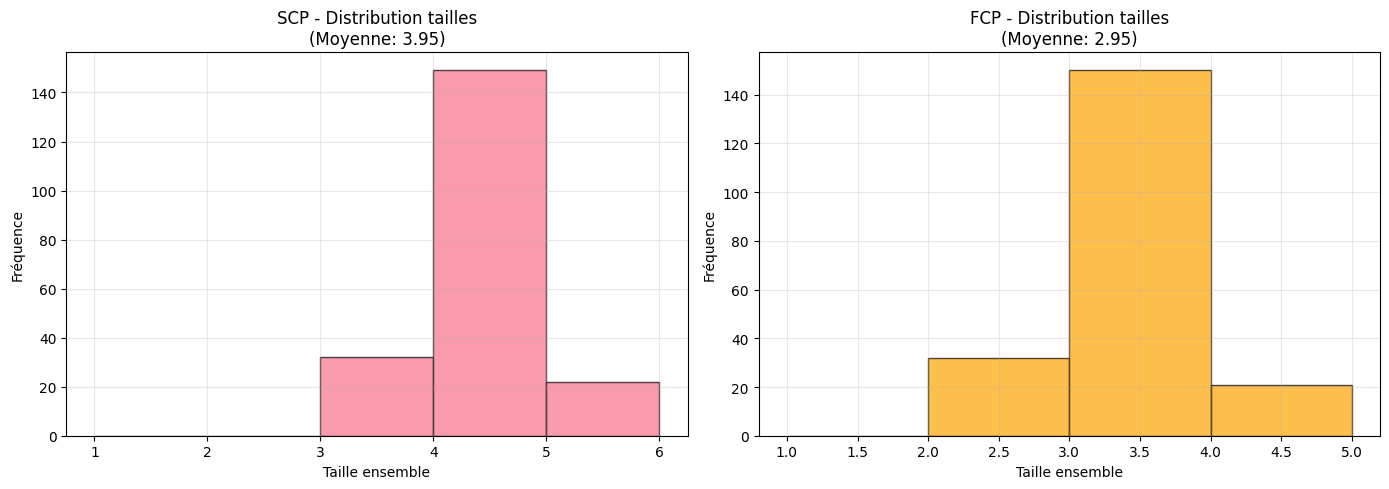


Résumé tailles :
SCP - Min: 3, Max: 5, Médiane: 4.0
FCP - Min: 2, Max: 4, Médiane: 3.0


In [16]:
# Distribution des tailles d'ensembles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

scp_sizes = [len(s) for s in scp_predictions]
axes[0].hist(scp_sizes, bins=range(1, max(scp_sizes)+2), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Taille ensemble')
axes[0].set_ylabel('Fréquence')
axes[0].set_title(f'SCP - Distribution tailles\n(Moyenne: {scp_avg_size:.2f})')
axes[0].grid(alpha=0.3)

fcp_sizes = [len(s) for s in fcp_predictions]
axes[1].hist(fcp_sizes, bins=range(1, max(fcp_sizes)+2), edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Taille ensemble')
axes[1].set_ylabel('Fréquence')
axes[1].set_title(f'FCP - Distribution tailles\n(Moyenne: {fcp_avg_size:.2f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRésumé tailles :")
print(f"SCP - Min: {min(scp_sizes)}, Max: {max(scp_sizes)}, Médiane: {np.median(scp_sizes)}")
print(f"FCP - Min: {min(fcp_sizes)}, Max: {max(fcp_sizes)}, Médiane: {np.median(fcp_sizes)}")

## 7. Conclusions

### Résultats

Avec alpha = 0.10 :
- **SCP** : Couverture de 97.04% avec taille moyenne de 3.95 classes
- **FCP** : Couverture de 87.19% avec taille moyenne de 2.95 classes

### Interprétation

La SCP offre une meilleure garantie de couverture mais avec des ensembles plus larges. La FCP produit des ensembles plus compacts mais nécessite un ajustement d'alpha (0.05) pour atteindre 90% de couverture.

Pour l'évaluation du risque de crédit, la **SCP est préférable** car :
- Garantie de couverture robuste (important pour la réglementation)
- Simplicité de mise en œuvre
- Efficacité computationnelle
- Transparence pour les parties prenantes

## 8. Application Professionnelle

Voir le fichier : **`../src/Application_Professionnelle_Credit_Classification.py`**

In [17]:
# Préparation des encodeurs
feature_encoders = {}
for col in ['Rating Agency Name', 'Sector']:
    le_temp = LabelEncoder()
    le_temp.fit(X_processed[col].astype(str))
    feature_encoders[col] = le_temp

print("✓ Encodeurs créés")
print(f"  - Rating Agency Name: {len(feature_encoders['Rating Agency Name'].classes_)} agences")
print(f"  - Sector: {len(feature_encoders['Sector'].classes_)} secteurs")

✓ Encodeurs créés
  - Rating Agency Name: 5 agences
  - Sector: 12 secteurs


In [18]:
import sys
import os

# Add the parent directory to the path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(notebook_dir)
src_path = os.path.join(parent_dir, 'src')

if src_path not in sys.path:
    sys.path.insert(0, src_path)

from Application_Professionnelle_Credit_Classification import CreditRatingPredictor, exemple_entreprise_saine, exemple_entreprise_risquee

predictor = CreditRatingPredictor(scp, le, feature_encoders)

# Évaluer une entreprise
company = exemple_entreprise_saine()
result = predictor.predict_with_interpretation(company)
predictor.display_prediction(result)

ÉVALUATION DU RISQUE DE CRÉDIT - TechCorp Solutions

Prédiction Conforme (90% de confiance):
  Ratings possibles: IG_MED, IG_LOW, IG_HIGH, SPEC_HIGH
  Taille de l'ensemble: 4

Prédiction Classique:
  Rating prédit: IG_MED
  Confiance: 43.5%

Interprétation: ⚠⚠ Faible confiance - Forte incertitude
  Incertitude élevée. Une analyse approfondie est nécessaire avant toute décision.



In [19]:
company = exemple_entreprise_risquee()
result = predictor.predict_with_interpretation(company)
predictor.display_prediction(result)

ÉVALUATION DU RISQUE DE CRÉDIT - Retail Inc.

Prédiction Conforme (90% de confiance):
  Ratings possibles: IG_LOW, SPEC_HIGH, IG_MED, SPEC_MED
  Taille de l'ensemble: 4

Prédiction Classique:
  Rating prédit: IG_LOW
  Confiance: 47.6%

Interprétation: ⚠⚠ Faible confiance - Forte incertitude
  Incertitude élevée. Une analyse approfondie est nécessaire avant toute décision.

